# Semi-Supervised Classification Using K-Means Classification and FixMatch

## Author

Tejas Srikanth, tcsrikan@uwaterloo.ca

## Abstract

Semi-supervised classification is a very important problem. There are many situations in which it is simply too costly or time-consuming to label all data. However, getting additional information from the unlabeled data can often be beneficial to the model that is being trained. 

Here, we outline an approach to semi-supervised classification leveraging supervised learning, K-means classification to ensure separability of the latent space distribution, and FixMatch loss to ensure consistent labeling across the unlabeled data. We will then analyze the training metrics after autotuning hyperparameters to get a deeper idea of what occurs during training. 

The FixMatch loss function was inspired by [FixMatch: Simplifying Semi-Supervised Learning with Consistency and Confidence](https://arxiv.org/pdf/2001.07685), a paper released in 2020. Here, we extend this approach by using K-means classification during training in conjunction with the FixMatch loss on the unlabeled dataset. The model will be trained on the CIFAR-10 dataset


## Motivation

The idea behind this approach is to learn using supervised learning, but also leverage the unlabeled data to get extra information. 

Now, define $D_l$ to be the distribution of labeled data and $D_u$ to be the distribution of unlabeled data.

Let $f_\theta$ be our model that we are training

Let $z_\theta(x) \in \mathbb{R}^{100}$ be the logits from the second to last layer of $f_\theta$

Let $p_\theta(y | x)$ for $x \sim D$ be the probability of predicting class y given x under parameters $\theta$. 

(NOTE: One can think of $p_\theta$ and $f_\theta$ as being equivalent)

### Supervised Loss $L_{sup}$

Our supervised loss will be cross-entropy on the labeled data:
$$
\begin{align*}
    L_{sup} = \mathbb{E}_{(x,y) \sim D_{sup}} \left[ -\log p_\theta(y|x) \right] = \mathbb{E}_{(x,y) \sim D_{sup}} \left[ -\sum_{i=1}^K y_i \log p_\theta(y_i|x) \right]
\end{align*}
$$

This ensures the network predicts ground truth labels where they exist

### FixMatch Consistency Loss $L_{augment}$

We want to ensure predictions don't change under augmentations. hence, we generate a pseudo-label from a weakly augmented image and enforce consistency on a strongly augmented image

Let $x \sim D_u$
Let $x_{weak}$ be the view of x after weak augmentation
Let $x_{strong}$ be the view of x after strong augmentation

This motivates the following process:

1. Compute
$$
\begin{align*}
    \hat{y} = \argmax_i p_\theta(i | x_{weak})
\end{align*}
$$

2. If $\max_i p_\theta(i | x_{weak}) \geq \tau$, treat $\hat{y}$ as true and penalize:
$$
\begin{align*}
    -\log p_\theta(\hat{y} | x_{strong})
\end{align*}
$$

Hence, we get the following term:
$$
\begin{align*}
    L_{augment} = -\mathbb{E}_{x \sim D_u} \left[\mathbb{I}\left(\max_i p_\theta (i | x_{weak}) \geq \tau\right)\log p_\theta(\hat{y} | x_{strong})\right]
\end{align*}
$$

### K-means Clustering Loss $L_{KMeans}$

We want to incentivise $z_\theta$ to follow the cluster assumption. That is, when we cluster $z_{theta}(x)$ for all $x \sim D_u$, we want to ensure that decision boundaries lie in low density regions in $\mathbb{R}^{100}$. 

This motivates the following process:

1. Fit K-means on all the logits $\{ z_\theta(x) | x \in D_u\}$ to get centroids $\{C_j\}$

2. Assign each x to its nearest centroid $C_{k(x)}$ and then penlize the square distance from $z_\theta(x)$ to x's respective centroid:

$$
\begin{align*}
    L_{KMeans} = \mathbb{E} \| z_\theta(x) - C_{k(x)} \|^2_2
\end{align*}
$$

In theory, this incentivizes $z_theta$ to output a representation of x that naturally form tight, well-separated clusters.

### Final loss function

Combining the above gives our training objective:

$$
\min_\theta L(\theta) = \min_\theta \lambda_{sup} L_{sup} + \lambda_{augment} L_{augment} + \lambda_{KMeans} L_{KMeans}
$$

## External Libraries

Many libraries used in our implementation would be considered as "standard" in Computer Vision projects or courses:

- ``torch`` / ``torchvision``: The main libraries for PyTorch. These provide the ability to create transformations and our own CNNs. This is extensively used for manipulating our tensors, providing loaders for our training and testing process, and to perform training & computations on CUDA. ``torch.utils.dataset`` also provides us with the dataset used for training

- ``sklearn``: Used for efficient KMeans classification on CPU

- ``numpy``: Used to manipulate tensors from ``torch``, helps convert PyTorch tensors to a form that ``sklearn`` can understand. 

- ``matplotlib``: Used specifically for the ``plt`` command, which plots an image. This is used to show the metrics from training.

- ``random``: Implementing label noise requires randomly selecting indexes to flip the labels.

- ``tqdm``: A library that displays a loading bar and approximates the time remaining per training epoch

In [ ]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Data loading and augmentation
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Clustering (for offline K-means)
from sklearn.cluster import KMeans
import numpy as np

# Optional utilities
import random

c:\Users\tejas_1n\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the Dataset using ``torch.utils.dataset``

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=transform)

testset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


## Generate Trainloaders

Let $D$ be the training set we are sampling from

Here, we partition our training set into $D_u$ and $D_l$. Our function takes an input M, the number of unlabeled points to contain in the dataset. 

If M=0, then $D_u$ is empty (hence $D_u$ is returned as None)

If M = $|D|$, then all of our points are unlabeled, implying $D_l$ is empty (hence $D_l$ is returned as None)

Otherwise, we shuffle and partition the training set such that $|D_u| = M$ and $|D_l| = |D| - M$

In [3]:
def generate_trainloaders(trainset, batch_size_label=64, batch_size_unlabel=1000, M=1000):

    indices = list(range(len(trainset)))
    random.shuffle(indices) 
    labeled_indices = indices[M:]
    unlabeled_indices = indices[:M]

    # No unlabeled data
    if M == 0:
        train_unlabeled_loader = None
        trainloader = DataLoader(Subset(trainset, labeled_indices), batch_size=batch_size_label,
                                          shuffle=True, num_workers=2)
    
    # No labeled data
    elif M == len(trainset):
        train_unlabeled_loader = DataLoader(Subset(trainset, unlabeled_indices), batch_size=batch_size_label,
                                          shuffle=True, num_workers=2)
        trainloader = None
    
    # Both labeled and unlabeled data
    else:
        train_unlabeled_loader = DataLoader(Subset(trainset, unlabeled_indices), batch_size=batch_size_unlabel,
                                          shuffle=True, num_workers=2)
        trainloader = DataLoader(Subset(trainset, labeled_indices), batch_size=batch_size_label,
                                          shuffle=True, num_workers=2)
        
    return trainloader, train_unlabeled_loader



## Model Class

Our network is a fairly standard CNN, with 2 convolutional layers and 3 fully connected layers. 

Given some $x \sim D_u$, we may want to return $z_\theta(x)$ for K-means classification of unlabeled data. 

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x, return_logits=False):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x_logits = F.relu(self.fc2(x))  
        x = self.fc3(x_logits)
        if return_logits:
            return x, x_logits
        else:
            return x

## Define augmentations

Given an $x \sim D_u$ this is what allows us to obtain $x_{weak}$ and $x_{strong}$

In [6]:
strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32, padding=4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
])

weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32, padding=4),
])


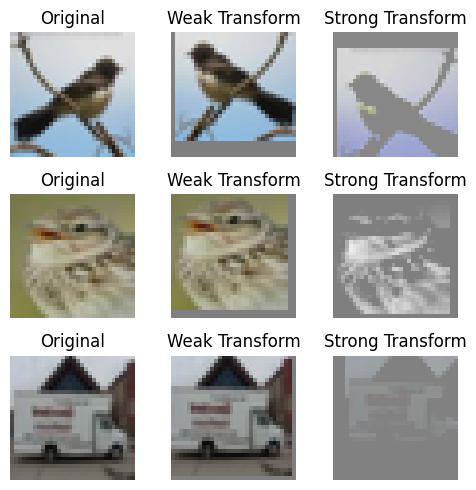

In [ ]:
### Select 3 random samples from the training set and
### apply the weak and strong transformations

indices = random.sample(range(len(trainset)), 3)
images, _ = zip(*[trainset[i] for i in indices])
strong_images = [strong_transform(img) for img in images]
weak_images = [weak_transform(img) for img in images]
fig, axes = plt.subplots(3, 3, figsize=(5, 5))

for i in range(3):
    # original image
    axes[i, 0].imshow(np.transpose(images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5) 
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    # weakly transformed image
    axes[i, 1].imshow(np.transpose(weak_images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5) 
    axes[i, 1].set_title("Weak Transform")
    axes[i, 1].axis("off")
    
    # strongly transformed image
    axes[i, 2].imshow(np.transpose(strong_images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5) 
    axes[i, 2].set_title("Strong Transform")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Training

For our train function, we pass in:

``Datasets``: trainset and testset

``Transforms``: weak_transform, strong_transforms

``TAU``: Which is the threshold for pseudo labels (default 0.95)

``M``: The number of unlabeled points in the trainset

``epochs``: Number of iterations to run the training loop

The main idea of the training loop is as follows:

1. For each batch in trainloader_labeled, we caluclate $L_{sup}$.
2. For each batch $B$ in trainloader_unlabeled, we get $x_{weak}$ and $x_{strong}$ for all $x \in B$
3. We then calculate the KMeans loss over the whole dataset. 

In [ ]:

torch.autograd.set_detect_anomaly(True)

def train(trainset=trainset, testset=testset, weak_transform=weak_transform, w_kmeans=0.25, w_augment=0.25, w_labeled=1,\
           strong_transform=strong_transform, TAU=0.95, run_kmeans=True, M=20000, epochs=30):

    # Initialize new model, optimizer, and loss function
    model = SimpleCNN()
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Check if GPU is available and move model and loss function to GPU if so
    device = 'gpu' if torch.cuda.is_available() else 'cpu'
    if device == 'gpu':
        model = model.cuda()
        criterion = criterion.cuda()

    # Generate the trainloaders for labeled and unlabeled data
    # M is the number of unlabeled data points to use for training
    # If M is 0, only labeled data will be used for training
    trainloader_labeled, trainloader_unlabeled =  generate_trainloaders(trainset, 64, 256, M)
    testloader = DataLoader(testset, batch_size=64, num_workers=2)

    labeled_losses = []
    unlabeled_augmentation_losses = []
    kmeans_losses = []
    valid_loss = []
    valid_accuracies = []

    for epoch in tqdm(range(epochs)): 

        ### Labeled data training ### 
        if trainloader_labeled:
            for i, (labeled_x, labeled_y) in enumerate(trainloader_labeled):
                
                labeled_x = labeled_x.to(device)
                labeled_y = labeled_y.to(device)

                z_labeled, _ = model(labeled_x, return_logits=True)

                L_sup = w_labeled * criterion(z_labeled, labeled_y)
                labeled_losses.append(L_sup.item())

                if i == 0:
                    optim.zero_grad()
                L_sup.backward()


        if trainloader_unlabeled:

            all_logits = torch.tensor([]).view(0, 100).to(device)

            ### Unlabeled data augmentation ###
            for i, data in enumerate(trainloader_unlabeled):
                
                # get current batch of unlabeled data and logits
                unlabeled_x_batch, _ = data # ignore labels
                _, logits_unlabeled = model(unlabeled_x_batch, return_logits=True)
                all_logits = torch.cat((all_logits, logits_unlabeled), 0) # concatenate logits to be used in kmeans

                # transform the unlabeled data using weak and strong augmentations
                x_weak, x_strong = weak_transform(unlabeled_x_batch), strong_transform(unlabeled_x_batch)

                # get the final outputs for the weak and strong augmented data
                z_weak, _ = model(x_weak, return_logits=True)
                z_strong, _ = model(x_strong, return_logits=True)

                # If the model is confident in its guess for z_weak 
                # (i.e., the max logit is above TAU), use that as a pseudo-label
                # and compute the consistency loss between z_strong and the pseudo-label
                pseudo_values, _ = torch.max(nn.Softmax(dim=1)(z_weak.detach()), dim=1)
                pseudo_labels = (pseudo_values >= TAU).float().to(torch.long).detach()
                corresponding_strong_transforms = z_strong[pseudo_labels]

                # Treat the pseudo labels as the ground truth for the strong augmented data
                # and compute the consistency loss
                L_consistency = criterion(corresponding_strong_transforms, pseudo_labels)
                loss_overall = L_consistency * w_augment
                unlabeled_augmentation_losses.append(L_consistency.item())

                loss_overall.backward()
            
            ### K-means clustering ###
            if run_kmeans:
                logits_cpu = all_logits.detach().cpu().numpy()
                with torch.no_grad():
                    kmeans = KMeans(n_clusters=10, n_init=10).fit(logits_cpu)
                    pseudo_labels = torch.tensor(kmeans.labels_).to(torch.long).to(device)
                    cluster_centers = torch.tensor(kmeans.cluster_centers_).to(device)
                    
                # Compute the K-means loss using the cluster centers and the logits
                L_kmeans = w_kmeans * torch.mean((all_logits - cluster_centers[pseudo_labels]) ** 2) 

                kmeans_losses.append(L_kmeans.item())

                L_kmeans.backward()

        optim.step()

        ### Validation on the test set ###
        with torch.no_grad():
            total_correct = 0
            total_loss = 0

            for i, (test_x, test_y) in enumerate(testloader):
                test_x.to(device)
                test_y.to(device)
                z_test = model(test_x, return_logits=False)
                z_cats = torch.argmax(z_test, dim=1)
                total_correct += torch.sum(z_cats == test_y).item()
                total_loss += criterion(z_test, test_y).item()

            valid_loss.append(total_loss)
            valid_accuracies.append(total_correct / len(testset))

    torch.save(model.state_dict(), f'models/SSL_model_{M}_{w_kmeans}.pth')
    return labeled_losses, unlabeled_augmentation_losses, kmeans_losses, valid_loss, valid_accuracies


## Testing

For reproducibility purposes. Given a model and a dataset, return the total loss over the dataset and the proportion of correct predictions

In [41]:
def test(model, testloader, device, criterion=nn.CrossEntropyLoss()):

    with torch.no_grad():
        total_correct = 0
        total_loss = 0

        for i, (test_x, test_y) in enumerate(testloader):
            test_x.to(device)
            test_y.to(device)
            z_test = model(test_x, return_logits=False)
            z_cats = torch.argmax(z_test, dim=1)
            total_correct += torch.sum(z_cats == test_y).item()
            total_loss += criterion(z_test, test_y).item()

        print(f"Proportion of correct predictions: {total_correct / len(testset)}")
        print(f"Total loss: {total_loss}")

## Metrics

Plot $L_{sup}$, $L_{augment}$, $L_{KMeans}$ over all iterations. Note that we calculate $L_{sup}$, $L_{augment}$ once per the whole batch, but we calculate $L_{KMeans}$ once over the entire training set. We also plot the validation loss and accuracy per epoch

In [8]:
def plot_metrics(labloss, augloss, kloss, validloss, validcorrect):
    
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    # Plot labeled loss
    axes[0].plot(np.arange(len(labloss)), labloss, label="Labeled Loss")
    axes[0].set_title("Labeled Loss")
    axes[0].set_xlabel("Iterations")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot augmentation loss
    axes[1].plot(np.arange(len(augloss)), augloss, label="Augmentation Loss")
    axes[1].set_title("Augmentation Loss")
    axes[1].set_xlabel("Iterations")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    # Plot K-means loss
    axes[2].plot(np.arange(len(kloss)), kloss, label="K-means Loss")
    axes[2].set_title("K-means Loss")
    axes[2].set_xlabel("Iterations")
    axes[2].set_ylabel("Loss")
    axes[2].legend()

    # Plot validation loss
    axes[3].plot(np.arange(len(validloss)), validloss, label="Validation Loss")
    axes[3].set_title("Validation Loss")
    axes[3].set_xlabel("Epochs")
    axes[3].set_ylabel("Loss")
    axes[3].legend()

    # Plot validation accuracy
    axes[4].plot(np.arange(len(validcorrect)), validcorrect, label="Validation Accuracy")
    axes[4].set_title("Validation Accuracy")
    axes[4].set_xlabel("Epochs")
    axes[4].set_ylabel("Accuracy")
    axes[4].legend()

    plt.tight_layout()
    plt.show()

    # Report maximum and final validation accuracy
    max_valid_accuracy = max(validcorrect)
    final_valid_accuracy = validcorrect[-1]
    print(f"Maximum Validation Accuracy: {max_valid_accuracy}")
    print(f"Final Validation Accuracy: {final_valid_accuracy}")

## Ablation Studies

Here, we do 2 main experiments with the training. 

In the first experiment, we adjust the size of the unlabeled dataset, M. We use the following values:
1. $M=0$ (Hence, all datapoints are labeled)
2. $M=50$
3. $M=5000$
4. $M=40000$
5. $M=50000$ (Hence all datapoints are unlabeled)

In the second experiment, we adjust the w_kmeans with respect to w_augment and w_labeled. This experiment tries to understand what happens when we emphasize w_kmeans more vs less, and how does this affect the kmeans loss over time. We use the following values
1. $w_kmeans=0.025, w_augment=0.25, w_labeled=1$
2. $w_kmeans=0.25, w_augment=0.25, w_labeled=1$
3. $w_kmeans=100, w_augment=0.125, w_labeled=0.5$

Notice in the fist experiment, w_kmeans is small compared to w_augment and w_labeled. In the last experiment, w_kmeans is large compaired to w_augment and w_labeled

### Experiment 1 - Adjusting M

In [39]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN()
testloader = DataLoader(testset, batch_size=64, num_workers=2)

100%|██████████| 35/35 [36:30<00:00, 62.60s/it]


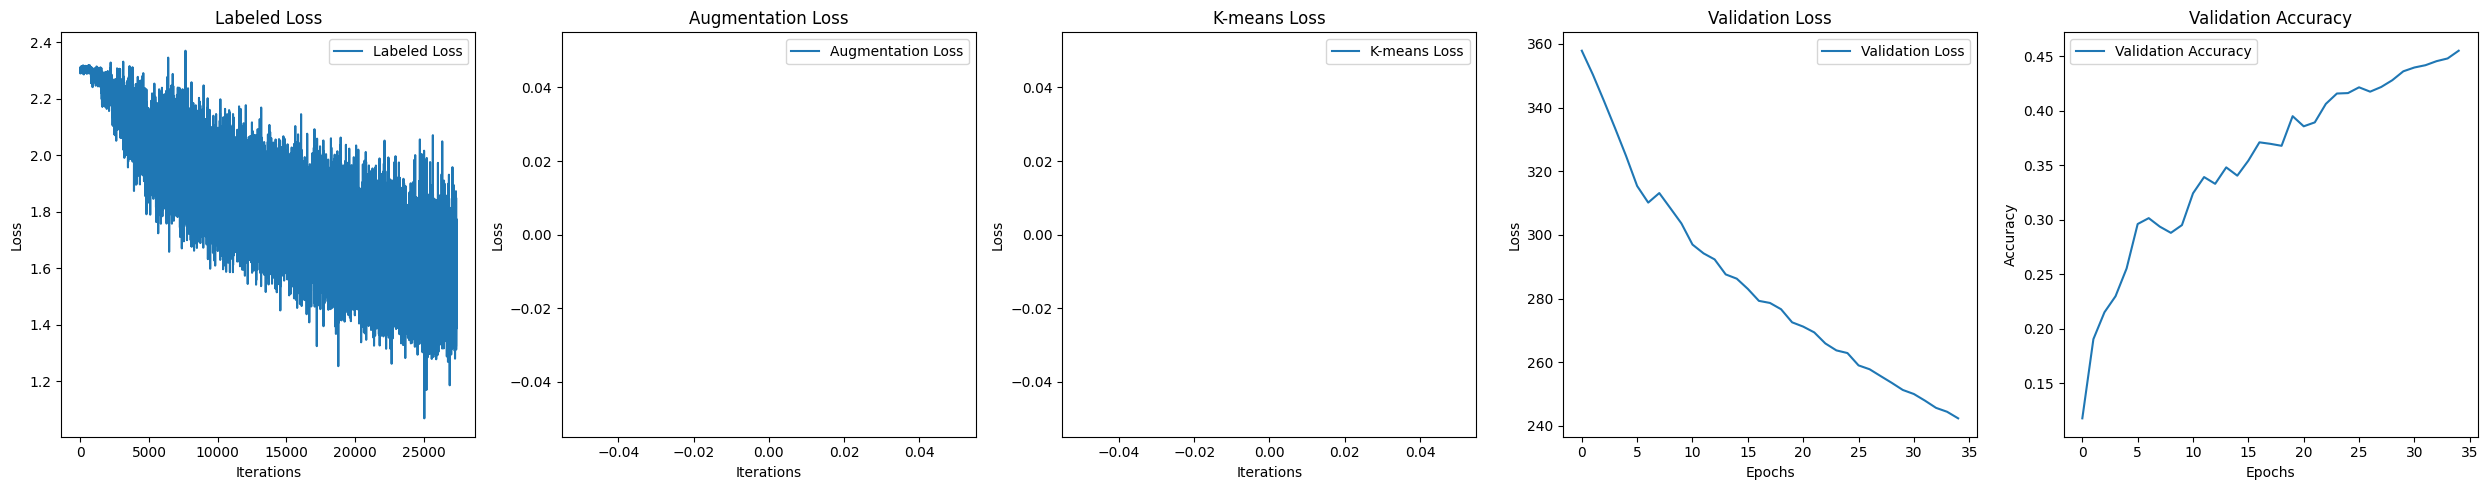

Maximum Validation Accuracy: 0.4551
Final Validation Accuracy: 0.4551


In [ ]:
lab0, aug0, kmeans0, validloss0, validcorrect0 = train(M=0, epochs=35)
plot_metrics(lab0, aug0, kmeans0, validloss0, validcorrect0)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_0_0.25.pth'))
# test(model, testloader, device)

100%|██████████| 31/31 [31:09<00:00, 60.30s/it]


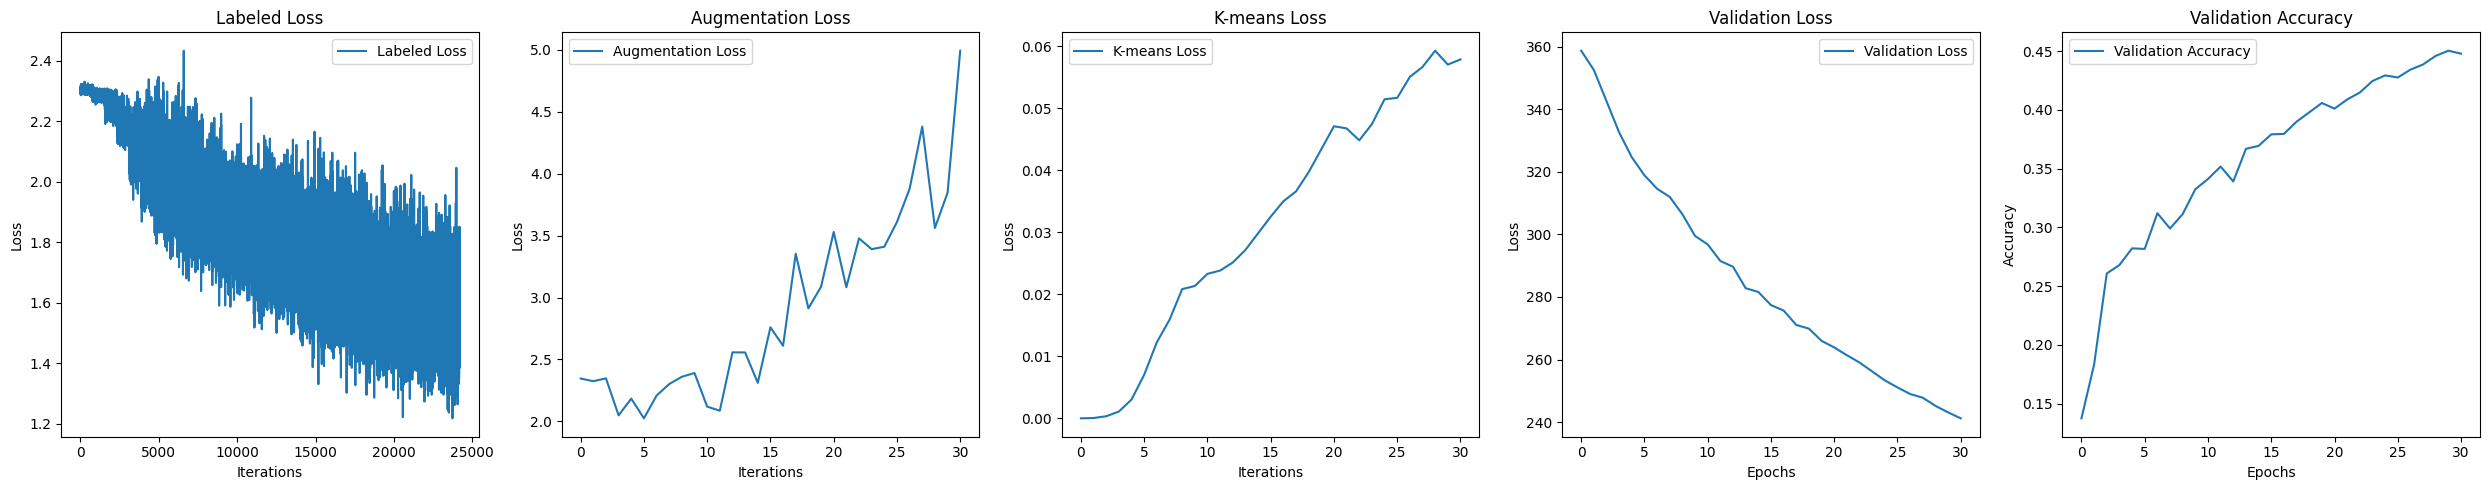

Maximum Validation Accuracy: 0.4504
Final Validation Accuracy: 0.4479


In [ ]:
lab50, aug50, kmeans50, validloss50, validcorrect50 = train(M=50, epochs=31)
plot_metrics(lab50, aug50, kmeans50, validloss50, validcorrect50)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_50_0.25.pth'))
# test(model, testloader, device)

100%|██████████| 58/58 [1:04:58<00:00, 67.21s/it]


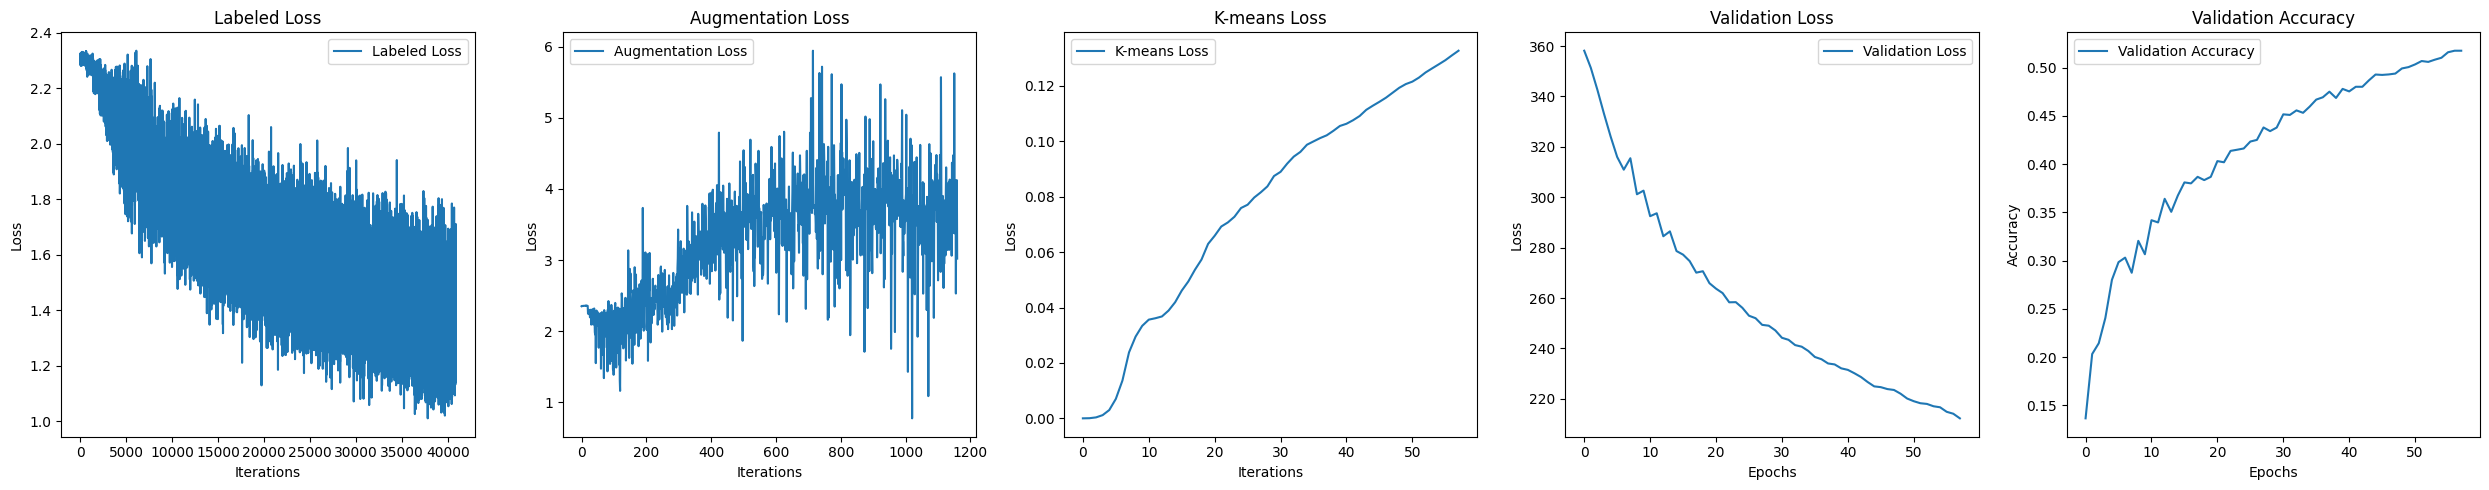

Maximum Validation Accuracy: 0.5177
Final Validation Accuracy: 0.5177


In [ ]:
lab5000, aug5000, kmeans5000, validloss5000, validcorrect5000 = train(M=5000, epochs=58)
plot_metrics(lab5000, aug5000, kmeans5000, validloss5000, validcorrect5000)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_5000_0.25.pth'))
# test(model, testloader, device)

100%|██████████| 54/54 [1:38:14<00:00, 109.15s/it]


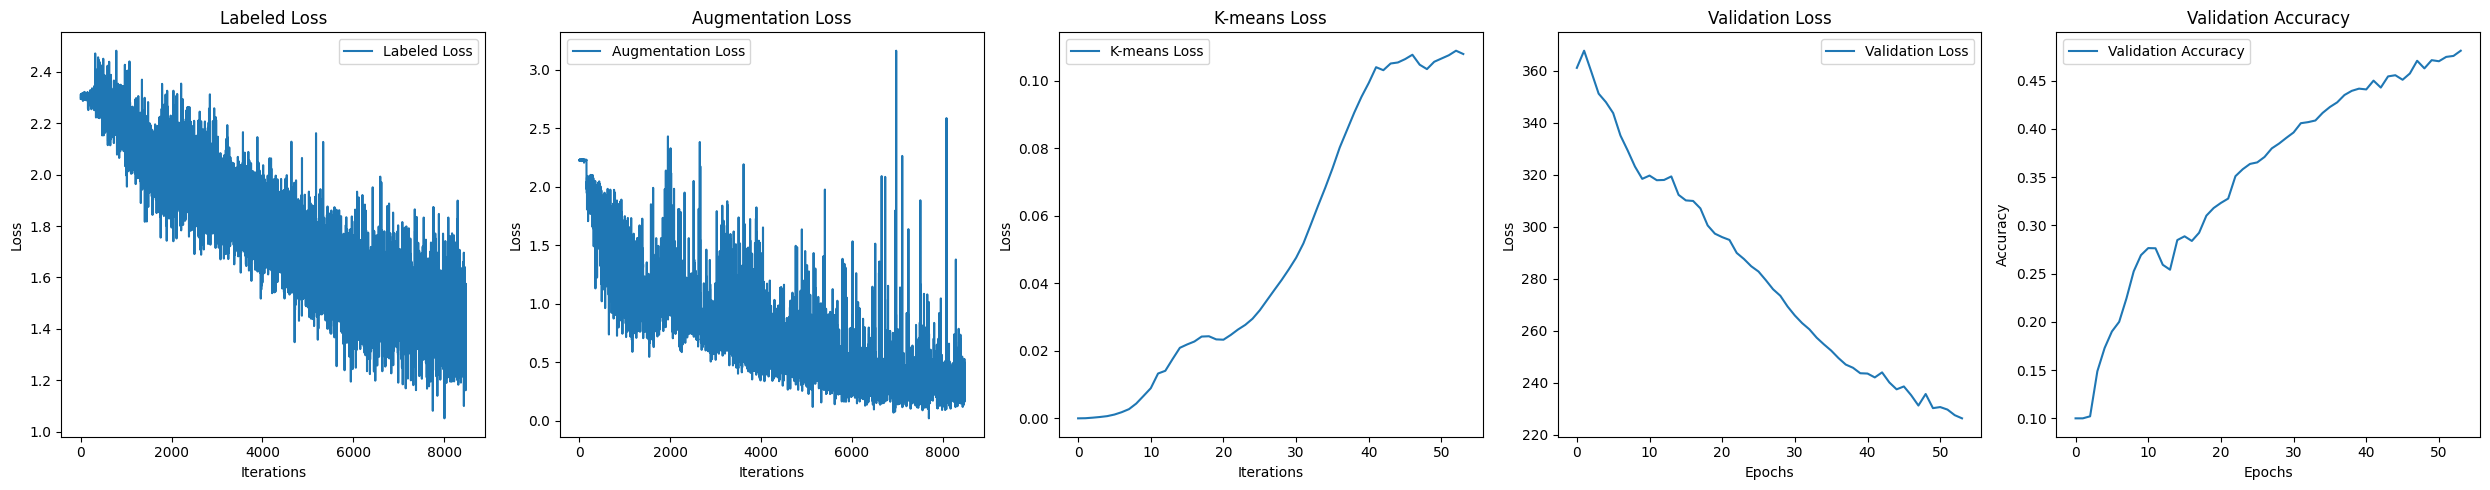

Maximum Validation Accuracy: 0.4809
Final Validation Accuracy: 0.4809


In [ ]:
lab40000, aug40000, kmeans40000, validloss40000, validcorrect40000 = train(M=40000, epochs=54)
plot_metrics(lab40000, aug40000, kmeans40000, validloss40000, validcorrect40000)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_40000_0.25.pth'))
# test(model, testloader, device)

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [2:00:49<00:00, 201.39s/it]  


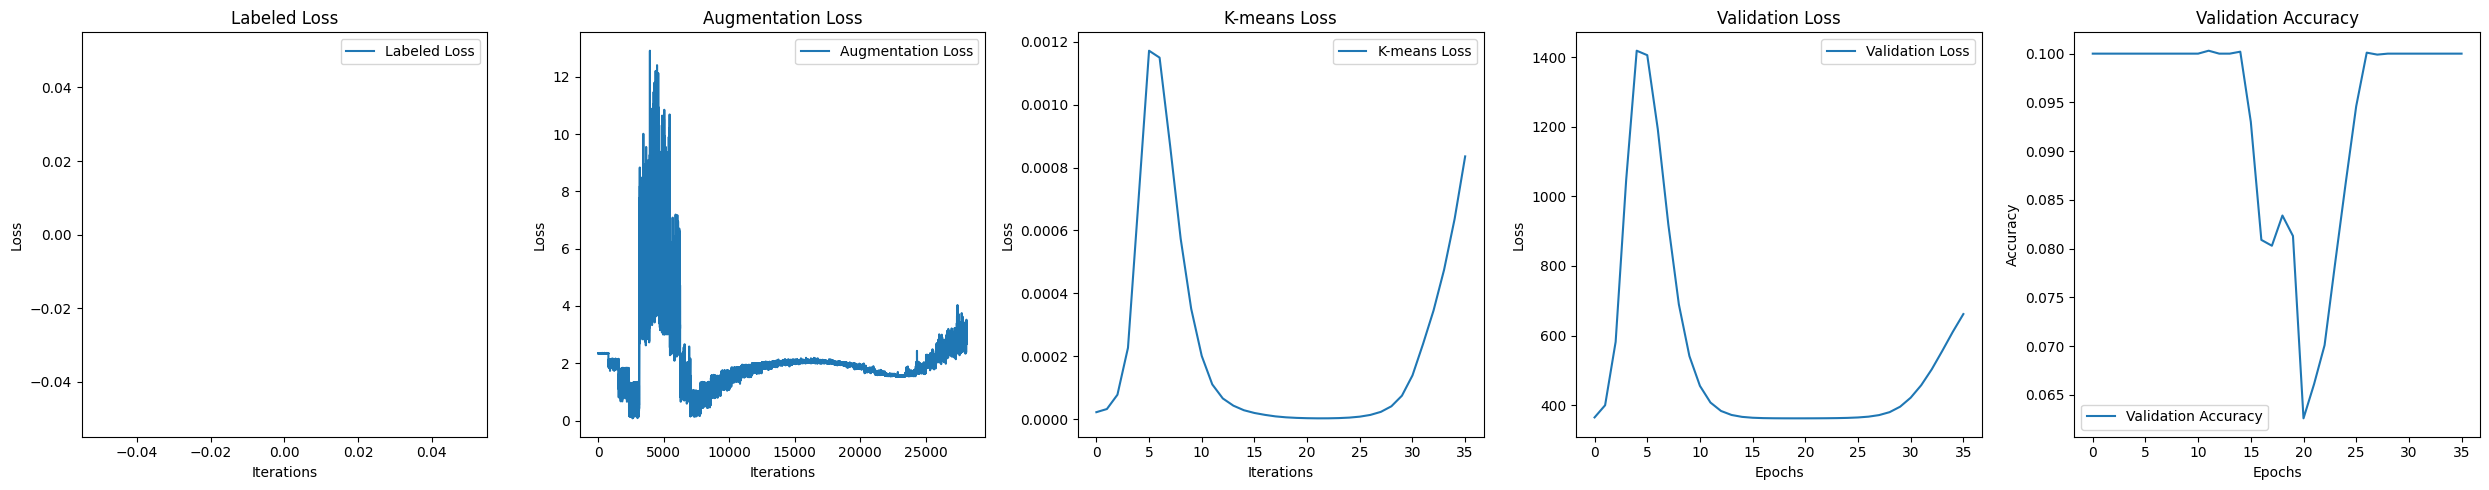

Maximum Validation Accuracy: 0.1003
Final Validation Accuracy: 0.1


In [ ]:
lab50000, aug50000, kmeans50000, validloss50000, validcorrect50000 = train(M=50000, epochs=36)
plot_metrics(lab50000, aug50000, kmeans50000, validloss50000, validcorrect50000)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_50000_0.25.pth'))
# test(model, testloader, device)

### Experiment 2 - Adjusting Loss Weights

100%|██████████| 35/35 [50:14<00:00, 86.13s/it]


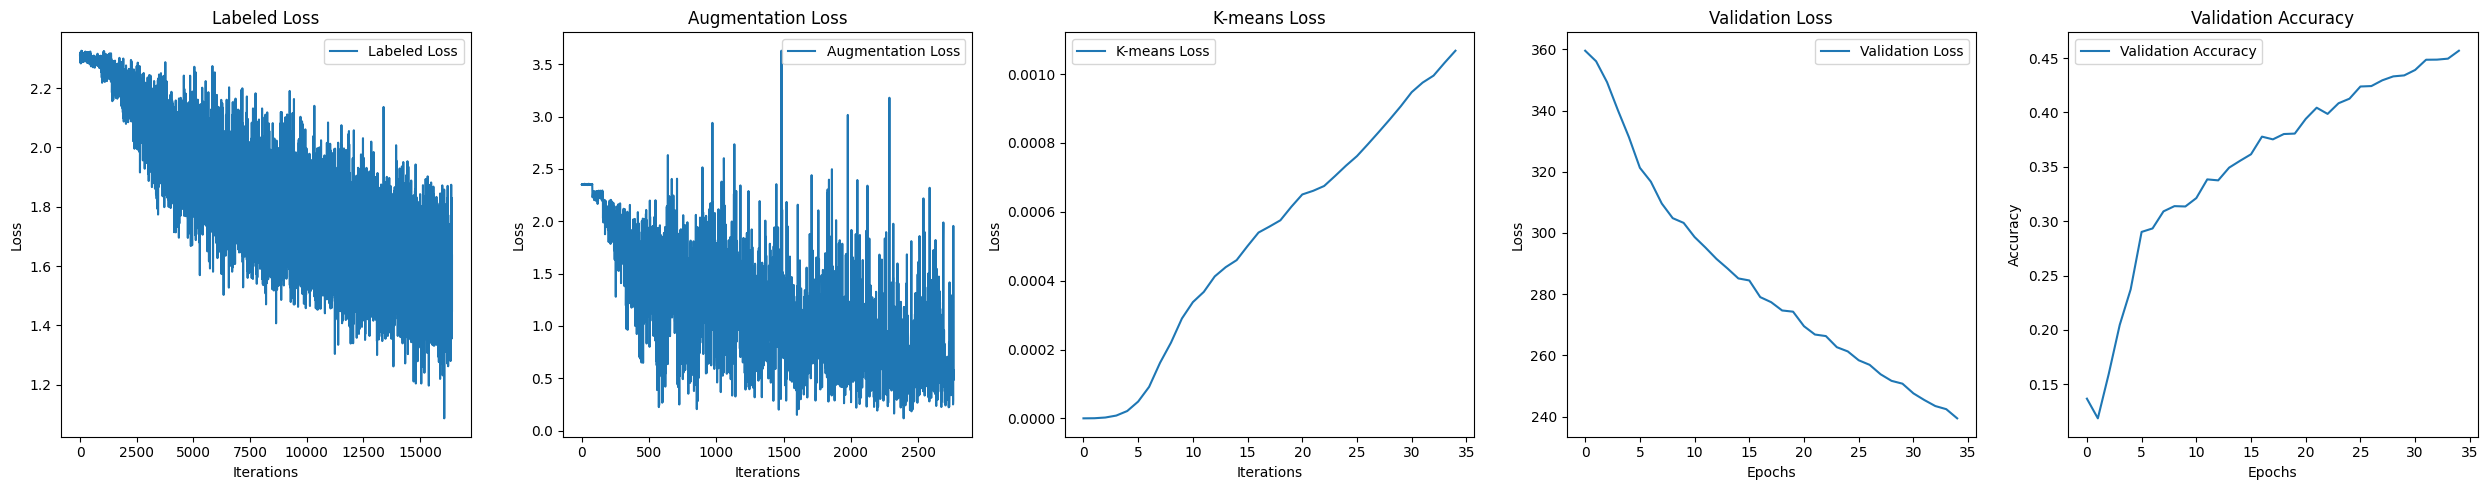

Maximum Validation Accuracy: 0.4567
Final Validation Accuracy: 0.4567


In [ ]:
lab_xsmall, aug_xsmall, kmeans_xsmall, validloss_xsmall, validcorrect_xsmall = train(M=20000, epochs=35, w_kmeans=0.0025, w_augment=0.25, w_labeled=1)
plot_metrics(lab_xsmall, aug_xsmall, kmeans_xsmall, validloss_xsmall, validcorrect_xsmall)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_20000_0.025.pth'))
# test(model, testloader, device)

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [50:18<00:00, 86.25s/it]


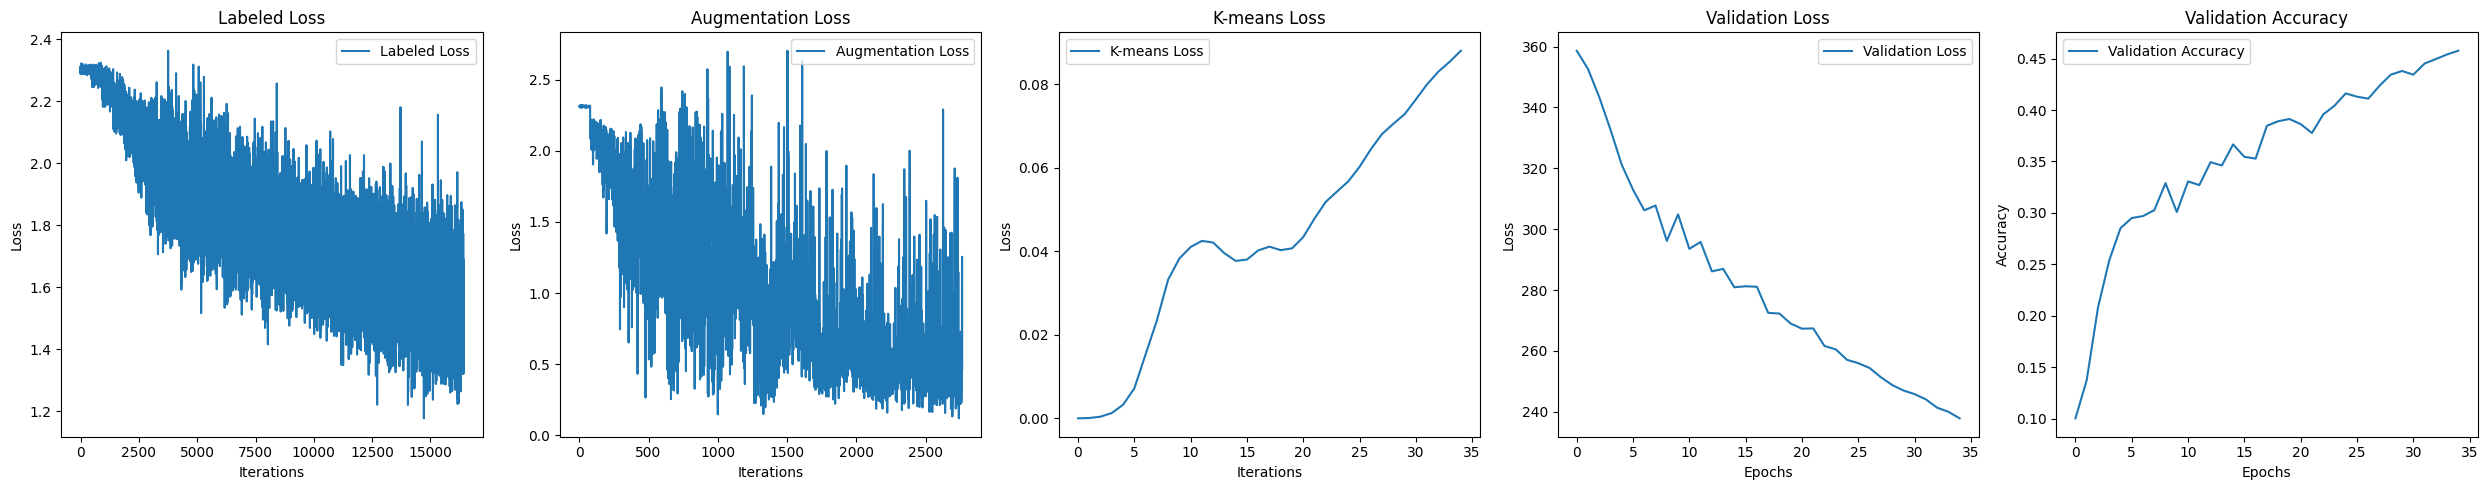

Maximum Validation Accuracy: 0.4577
Final Validation Accuracy: 0.4577


In [ ]:
lab_small, aug_small, kmeans_small, validloss_small, validcorrect_small = train(M=20000, epochs=35, w_kmeans=0.25, w_augment=0.25, w_labeled=1)
plot_metrics(lab_small, aug_small, kmeans_small, validloss_small, validcorrect_small)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_20000_0.25.pth'))
# test(model, testloader, device)

100%|██████████| 35/35 [48:35<00:00, 83.30s/it]


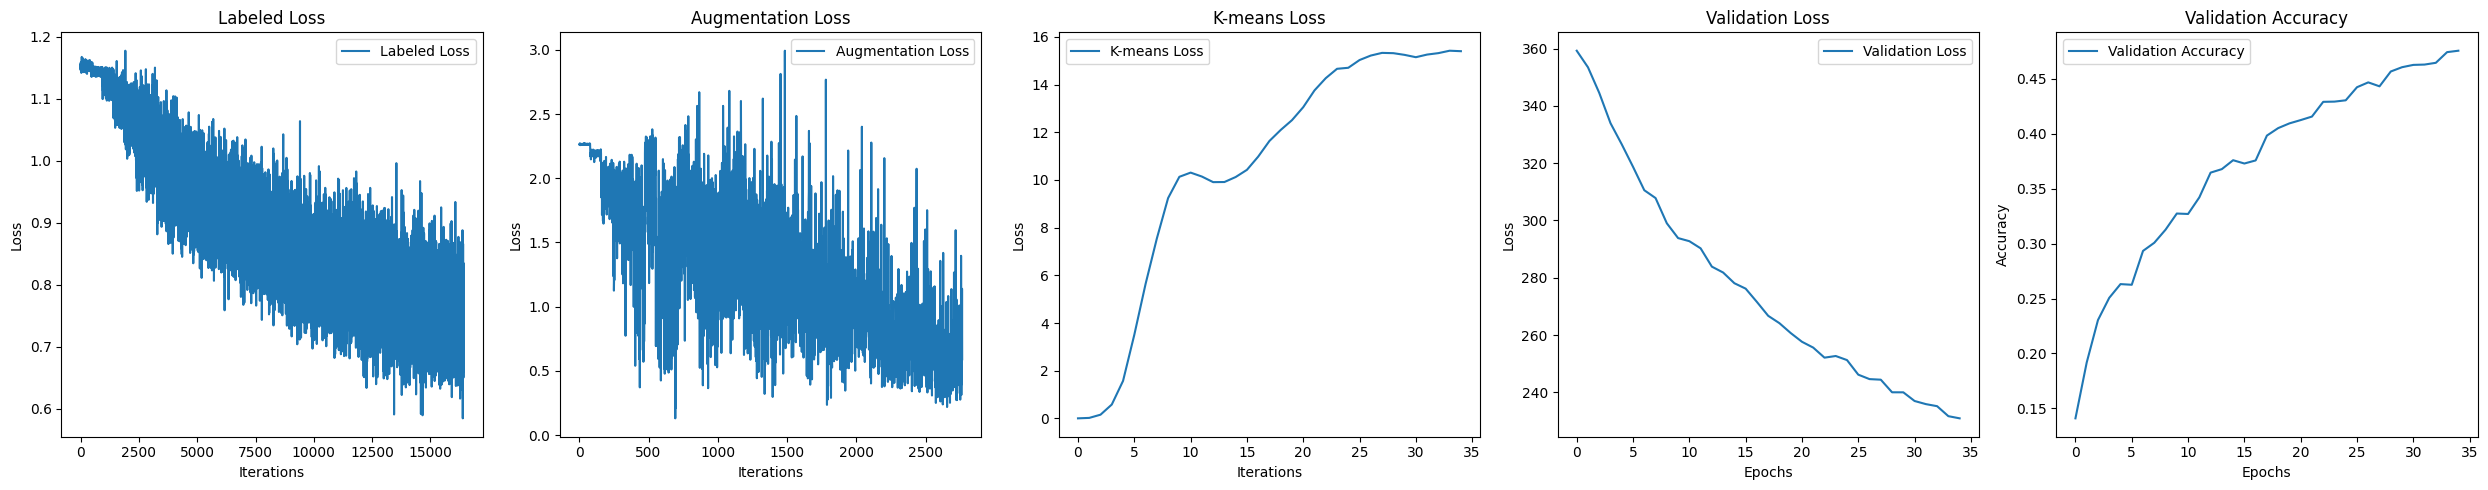

Maximum Validation Accuracy: 0.4754
Final Validation Accuracy: 0.4754


In [ ]:
lab_large, aug_large, kmeans_large, validloss_large, validcorrect_large = train(M=20000, epochs=35, w_kmeans=100, w_augment=0.125, w_labeled=0.5)
plot_metrics(lab_large, aug_large, kmeans_large, validloss_large, validcorrect_large)

## Reproduce validation results:
# model.load_state_dict(torch.load(f'models/SSL_model_20000_100.pth'))
# test(model, testloader, device)

## Conclusions

#### Overall Conclusions

The supervised losses and the augmentation losses are quite noisy as we sampled one loss per batch. On the other hand, for K-means loss, and the validation losses and accuracy we sampled one per epoch. Hence, the latter 3 metrics were a lot more stable. In addition, almost every model had a validation accuracy of around 0.475, which is much better than random chance (0.1). 

Furthermore, for almost every model, the validation losses seem to be continuing on a downward trend after we stopped implying that many of our models likely hadn't yet converged. This is also evident in the fact that the maximum validation accuracy for most experiments is equal to the final validation accuracy. Thus, more training is likely required to get the true model validation accuracy.

#### Conclusions - Experiment 1

In terms of the augmentation loss, as the size of the unlabeled set increased, the change in training loss decreased. That is, if the size of the unlabeled set was small, then augmentation loss tended to increase more. If the size of the unlabeled set was large, the augmentation loss tended to decrease. 

This is likely due to the fact that only data points $x \in D_u$ such that $\max_i p_\theta(i | x_{weak}) >= \tau$ were accounted for in the loss. For smaller unlabeled dataset, there were far less ($x_{weak}$, $x_{strong}$) pairs for the model to learn from. Hence, the losses tended to increase.

Another interesting result was the fact that in all of these experiments, the validation accuracy was greater than 0.4. That is, the model got at least 40% of the data points right on almost all experiments except for the final one. In the final experiment M=50000=$|D|$. In this experiment, the model only got 10% of its predictions correct, on par with random chance. 

The reason for the above is that while our model can learn to create representations of the $x \in D$ such that the predictions are consistent under augmentation and the representations form tight clusters, there is still no supervision. Hence, what we might think of as a plane could really be anything as far as the model is concerned as it has no ground truth to work off of. Hence, the model for such a training set partition (50000 unlabeled points) will not result in a working model without some form of ground truth.

#### Conclusions - Experiement 2

The main takeaway from this experiment was that as we increased the weight for the KMeans loss, the KMean loss curve tended to flatten out more. When w_kmean = 0.025, the KMean loss never flattened, and only continued to increase. When w_kmean = 0.25, the KMean loss flattened out around epochs 10-20 and increased. When w_kmean = 100 and w_labeled = 0.5, w_augment = 0.125, the KMeans loss actually flattened out. 

As we increased w_kmean, the derivative updates tended to favour $L_{KMean}$. Thus, our KMean objective flattened out (but didn't decrease). Interestingly enough, the rate of decrease for $L_{sup}$ remained the same for all 3 experiments. This is likely because the 2 losses tend to go hand in hand. 

Let $x \in D_u$, if $z_\theta(x)$ gives us a tight, clustered representation of x. Then, labeled classification becomes easier as well. 

Let us assume $z_\theta(x)$ gives us a tight, clustered representation of x. Let $x_1, x_2$ be 2 images. Assume that $z_\theta(x_1)$ and $z_\theta(x_2)$ are close together. That is $\| z_\theta(x_1) - z_\theta(x_2)\|^2_2 < \epsilon$. Then, they are likely in the same category. Hence, the final layer of $f_\theta$ will likely classify both $x_1$ and $x_2$ in the same category. Most of the time, this is what we want. Hence why the supervised loss continues to decrease even when we emphasize the kmeans loss. 

#### Conclusions - Main Takeaways

1. Almost all models (except M=50000) performed better than random chance
2. Direction of augmented loss changes as M increases
3. KMean loss tends to flatten as you increase its contribution to the main loss

#### Future Work

None of the models above have been run to convergence. Running one model to convergence will likely take 3-4 hours, maybe less if using more sophisticated hardware. 

In addition, playing around with the model architecture. Seeing if a deeper model, or even a less deep model, could potentially improve the performance of the network. 